It contains 1,797 8 × 8 grayscale images of 10 digits. Split the data into a train set and a test set,
and then train and test the following classifiers for recognizing 10 digits.

In [7]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

X = digits.data      # The 8x8 image data, flattened into 64 features
y = digits.target    # The digit labels (0 through 9)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


1. Stack image pixels into a 64 × 1 vector and train a logistic regression model with elastic net
regularization. Use grid search to find the optimal values of the regularization parameters.
Find the accuracy of the trained model on the test data.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)

# Grid of hyperparameters
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Grid search with 5-fold cross-validation
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# Evaluate best model on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("Best parameters found:", grid.best_params_)
print("Test accuracy: {:.4f}".format(accuracy))


Best parameters found: {'C': 10, 'l1_ratio': 0.5}
Test accuracy: 0.9759


2. Stack image pixels into a 64×1 vector and train a MLP model with one or two hidden layers.
Use grid search to find the optimal configuration of the MLP (number of hidden layers and
number of nodes at each hidden layer). Plot the training loss versus the number of epochs
and also the accuracy versus the number of epochs in training the network with the optimal
configuration. Find the accuracy of the trained model on the test data.

Architecture [64] - Test Accuracy: 0.8500
Architecture [100] - Test Accuracy: 0.8556
Architecture [100, 50] - Test Accuracy: 0.8963
Architecture [64, 64] - Test Accuracy: 0.9037

Best architecture: [64, 64], Accuracy: 0.9037

Epoch 10/50, Loss: 0.3568, Train Accuracy: 0.8910
Epoch 20/50, Loss: 0.0864, Train Accuracy: 0.9698
Epoch 30/50, Loss: 0.0245, Train Accuracy: 0.9952
Epoch 40/50, Loss: 0.0101, Train Accuracy: 0.9984
Epoch 50/50, Loss: 0.0043, Train Accuracy: 1.0000


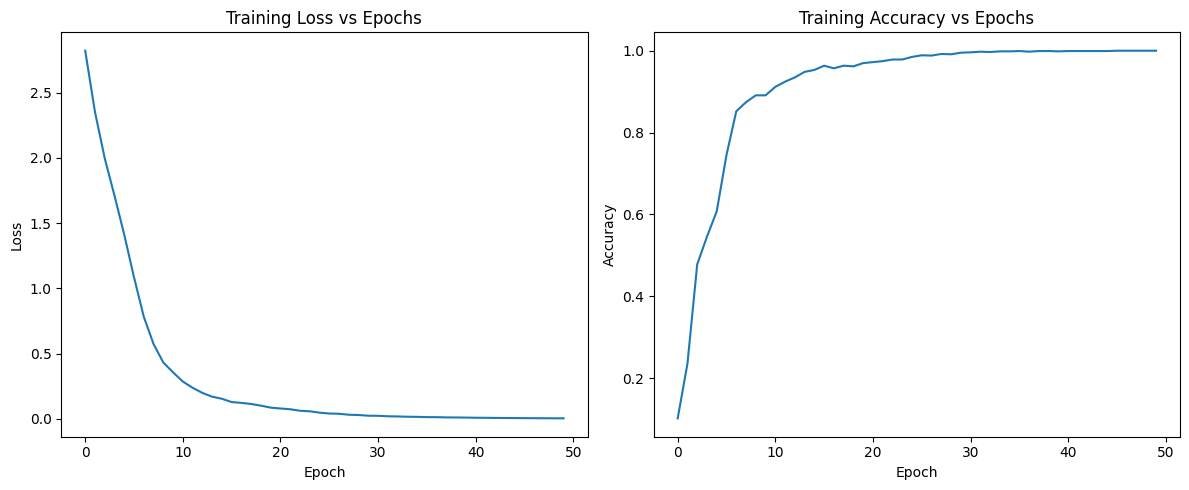

Final Test Accuracy with best architecture: 0.9704


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class MLP(nn.Module):
    def __init__(self, input_size=64, hidden_sizes=[100, 50], num_classes=10):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            in_size = h
        layers.append(nn.Linear(in_size, num_classes))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)


architectures = [
    [64],        # 1 hidden layer
    [100],
    [100, 50],   # 2 hidden layers
    [64, 64]
]

best_acc = 0
best_arch = None

for arch in architectures:
    model = MLP(hidden_sizes=arch)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(10):
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        _, val_preds = torch.max(val_outputs, 1)
        val_acc = (val_preds == y_test_tensor).float().mean().item()

    print(f"Architecture {arch} - Test Accuracy: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_arch = arch

print(f"\nBest architecture: {best_arch}, Accuracy: {best_acc:.4f}\n")

epochs = 50
model = MLP(hidden_sizes=best_arch)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_list = []
acc_list = []

for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track
    loss_list.append(loss.item())
    _, predicted = torch.max(outputs, 1)
    acc = (predicted == y_train_tensor).float().mean().item()
    acc_list.append(acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Train Accuracy: {acc:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(acc_list)
plt.title("Training Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)
    test_accuracy = (test_preds == y_test_tensor).float().mean().item()

print(f"Final Test Accuracy with best architecture: {test_accuracy:.4f}")


3. Train a convolutional neural network with one or two convolutional layers using the images.
Use grid search to find the optimal configuration of the MLP (number of convolutional layers
and number of filters at each convolutional layer). Plot the training loss versus the number
of epochs and also the accuracy versus the number of epochs in training the network with
the optimal configuration. Find the accuracy of the trained model on the test data.

Architecture [(8, 3)] -> Test Accuracy: 0.7593
Architecture [(16, 3)] -> Test Accuracy: 0.7926
Architecture [(8, 3), (16, 3)] -> Test Accuracy: 0.7130
Architecture [(16, 3), (32, 3)] -> Test Accuracy: 0.7907

Best architecture: [(16, 3)] with test accuracy: 0.7926

Epoch 10, Loss: 1.7650, Accuracy: 0.7971
Epoch 20, Loss: 0.4732, Accuracy: 0.9037
Epoch 30, Loss: 0.1402, Accuracy: 0.9610
Epoch 40, Loss: 0.0562, Accuracy: 0.9849
Epoch 50, Loss: 0.0219, Accuracy: 0.9968


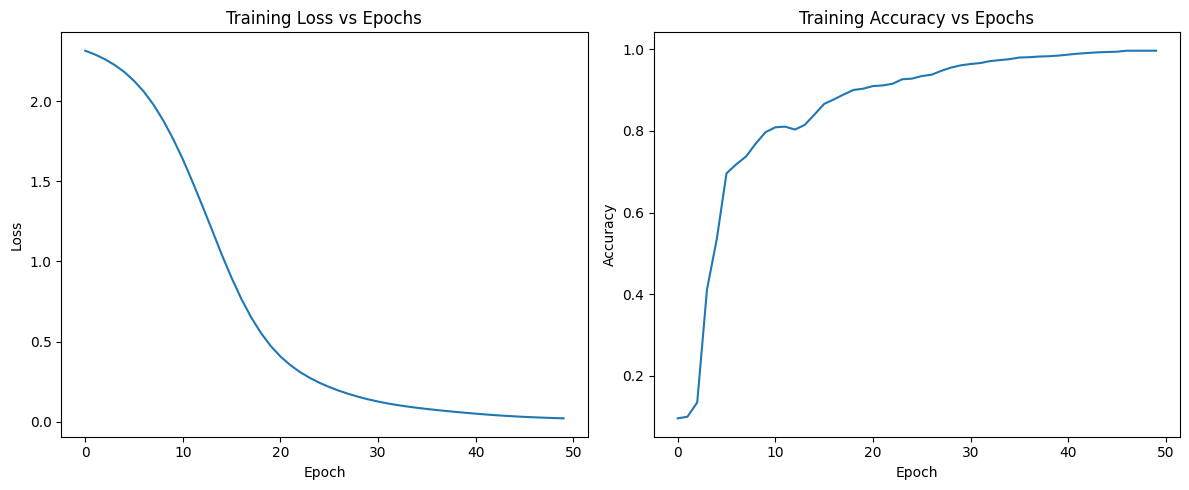

Final Test Accuracy: 0.9759


In [10]:
X = digits.images  # instead of digits.data
y = digits.target    # The digit labels (0 through 9)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
#redo test train split because we need to use images instead of the flattened

X_train = X_train / 16.0
X_test = X_test / 16.0

# Reshape: add channel dimension (from [N, 8, 8] to [N, 1, 8, 8])
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class SimpleCNN(nn.Module):
    def __init__(self, conv_layers=[(8, 3)], fc_size=32):
        super(SimpleCNN, self).__init__()
        layers = []
        in_channels = 1

        # Convolutional layers
        for out_channels, kernel_size in conv_layers:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)

        # Calculate flattened output size (assumes 8x8 input)
        dummy_input = torch.zeros(1, 1, 8, 8)
        dummy_output = self.conv(dummy_input)
        flat_size = dummy_output.view(1, -1).shape[1]

        # Fully connected classifier
        self.fc = nn.Sequential(
            nn.Linear(flat_size, fc_size),
            nn.ReLU(),
            nn.Linear(fc_size, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    

architectures = [
    [(8, 3)],
    [(16, 3)],
    [(8, 3), (16, 3)],
    [(16, 3), (32, 3)]
]

best_acc = 0
best_arch = None

for arch in architectures:
    model = SimpleCNN(conv_layers=arch)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Quick training for comparison
    for epoch in range(10):
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, preds = torch.max(test_outputs, 1)
        acc = (preds == y_test_tensor).float().mean().item()

    print(f"Architecture {arch} -> Test Accuracy: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_arch = arch

print(f"\nBest architecture: {best_arch} with test accuracy: {best_acc:.4f}\n")

model = SimpleCNN(conv_layers=best_arch)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 50
loss_list = []
acc_list = []

for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    _, preds = torch.max(outputs, 1)
    acc = (preds == y_train_tensor).float().mean().item()
    acc_list.append(acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(acc_list)
plt.title("Training Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)
    test_acc = (test_preds == y_test_tensor).float().mean().item()

print(f"Final Test Accuracy: {test_acc:.4f}")